#  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
orig_df = pd.read_csv('C:/Users/bapat/OneDrive/Desktop/CSULB_Course/03 - Fall 23/PR/02 - Assignments/Assignment04/datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
df = pd.read_csv('C:/Users/bapat/OneDrive/Desktop/CSULB_Course/03 - Fall 23/PR/02 - Assignments/Assignment04/datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [4]:
df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [5]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time','VictimCount']]

In [7]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.

## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 

In [9]:
df.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,0.663899,0.594478,0,0,0,0,0
1,0.552832,0.580495,1,1,1,1,0
2,0.623467,0.576165,2,1,2,0,1
3,0.563860,0.543189,3,1,1,2,2
4,0.599006,0.531973,4,1,1,3,0


#### Columns in the dataframe
From the above data, the X and Y columns represent the X and Y coordinate values of the location of the crime. The area_command represents the police designation of the bureau of the operation and NIBRSOffenceCode gives the classification code of the offense taken place. The DayOfTheWeek represent the days of the week in the form of 0-6. Then there is the Time column for the hour at which the crime took place and the VictimCount is the number of victims against which the crime took place.

#### The input variables are the X, Y, Area_command, NIBRSOffenseCode, DayOfWeek and Time.

#### The target variable is the VictimCount.

In [10]:
# Calculate the range for each column
column_ranges = df.max() - df.min()
column_ranges

X                    1.0
Y                    1.0
Area_Command        11.0
NIBRSOffenseCode     2.0
DayOfWeek            6.0
Time                23.0
VictimCount          6.0
dtype: float64

THe X and Y columns need normalizing because these values are not scaled and gradient descent works best on scaled values. Therefore we normalize data using min-max scalar.

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fit and transform the scaler on the 'X' and 'Y' columns
df[['X', 'Y']] = scaler.fit_transform(df[['X', 'Y']])

In [12]:
df.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,0.663899,0.594478,0,0,0,0,0
1,0.552832,0.580495,1,1,1,1,0
2,0.623467,0.576165,2,1,2,0,1
3,0.563860,0.543189,3,1,1,2,2
4,0.599006,0.531973,4,1,1,3,0


# Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [13]:
# Extract input_data and output_data from the DataFrame
input_col = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']].values
target_col = df['VictimCount'].values

In [14]:
# Convert the data to PyTorch tensors
input_tensor = torch.tensor(input_col, dtype=torch.float32)
target_tensor = torch.tensor(target_col, dtype=torch.float32)

In [17]:
#Define batch size
batch_size = 20

In [15]:
# Create TensorDatasets for training and testing
from torch.utils.data import TensorDataset, DataLoader
train = TensorDataset(input_tensor[:200], target_tensor[:200])
test = TensorDataset(input_tensor[200:], target_tensor[200:]) 

In [29]:
len(train)

200

In [30]:
len(test)

75

In [18]:
# Create DataLoader objects
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [32]:
for batch in train_dataloader:
    input_batch, output_batch = batch
    print("Input Batch Shape:", input_batch.shape)
    print("Output Batch Shape:", output_batch.shape)
    break

Input Batch Shape: torch.Size([20, 6])
Output Batch Shape: torch.Size([20])


# Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

### Loss function: 
The loss function that I would be using for this problem is Mean-Squared-Error. MSE is the loss function widely used for regression problems and is defined as:

$$
   MSE = 1/N \sum_i (y_i - \hat{y_i})^2
$$

where N is the number of samples. Summation is from i = 1 to N and yi is the expected values and yi^ is the predicted output.

### Size of predicted output
Because this is a regression problem and we would be predicting 1 real number,the size of the predicted output will be 1.

### Architecture of the neural network
Initially, the neural network that I would be using would have 1 input layer, 1 hidden layer and an output layer.
The input layer would have a size of 6 as there are 6 input features to feed in the network, the hidden layer will have 64 neurons in its layer and the output layer will have a single perceptron as we are predicting a real number as the output.

In [24]:
import torch.nn as nn

In [25]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [27]:
input_size = 6
hidden_size = 64
output_size = 1

In [28]:
model = RegressionModel(input_size, hidden_size, output_size)

In [18]:
criterion = nn.MSELoss()

### Optimizer for the neural network
The optimizer that I would be using is the Stochastic Gradient descent. The gradient descent is used for finding the local minima or maxima of the objective function. It helps to minimize the cost function.

Initially, I would be using the learning_rate = 0.01 and then checking the results.

In [20]:
import torch.optim as optim

In [29]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [20]:
for inputs, targets in train_dataloader:
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    targets = targets.view(-1, 1)
    # Compute the loss
    loss = criterion(outputs, targets)

    # Backpropagation
    loss.backward()
    # Update the weights
    optimizer.step()

    # Print the loss for this epoch
    print(' Loss:' + str(loss.item()))


 Loss:0.43587684631347656
 Loss:9.900419235229492
 Loss:4505153.0
 Loss:1736.2291259765625
 Loss:1691.521728515625
 Loss:1620.826904296875
 Loss:1533.3251953125
 Loss:1472.7369384765625
 Loss:1432.975341796875
 Loss:1379.9605712890625


In [21]:
# Training loop
num_epochs = 100  # Number of training epochs
for epoch in range(num_epochs):
    total_loss = 0.0
    total_samples = 0

    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(inputs)
        total_samples += len(inputs)

    # Calculate MSE on test data at the end of each epoch
    total_mse = 0.0
    total_test_samples = 0
    with torch.no_grad():  # Ensure no gradient computation during evaluation
        for test_inputs, test_targets in test_dataloader:
            test_outputs = model(test_inputs)
            total_mse += criterion(test_outputs, test_targets) * len(test_inputs)
            total_test_samples += len(test_inputs)
    
    mse = total_mse / total_test_samples
    avg_loss = total_loss / total_samples
    
    # Print the training loss and test MSE at the end of each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Avg. Training Loss: {avg_loss:.4f}, Test MSE: {mse.item():.4f}')


C:\Users\bapat\anaconda3\envs\ai_assignment01\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\bapat\anaconda3\envs\ai_assignment01\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Avg. Training Loss: 1101.1217, Test MSE: 861.0634
Epoch [2/100], Avg. Training Loss: 735.3682, Test MSE: 573.0739
Epoch [3/100], Avg. Training Loss: 491.1804, Test MSE: 381.1876
Epoch [4/100], Avg. Training Loss: 328.1548, Test MSE: 253.4609
Epoch [5/100], Avg. Training Loss: 219.3413, Test MSE: 168.4921
Epoch [6/100], Avg. Training Loss: 146.6859, Test MSE: 111.9827
Epoch [7/100], Avg. Training Loss: 98.1760, Test MSE: 74.4445
Epoch [8/100], Avg. Training Loss: 65.7774, Test MSE: 49.5396
Epoch [9/100], Avg. Training Loss: 44.1551, Test MSE: 33.0437
Epoch [10/100], Avg. Training Loss: 29.7135, Test MSE: 22.1279
Epoch [11/100], Avg. Training Loss: 20.0752, Test MSE: 14.9326
Epoch [12/100], Avg. Training Loss: 13.6400, Test MSE: 10.1935
Epoch [13/100], Avg. Training Loss: 9.3376, Test MSE: 7.0856
Epoch [14/100], Avg. Training Loss: 6.4687, Test MSE: 5.0601
Epoch [15/100], Avg. Training Loss: 4.5533, Test MSE: 3.7463
Epoch [16/100], Avg. Training Loss: 3.2750, Test MSE: 2.8

In [30]:
#Building the neural network with increased number of layers
class RegressionModel2(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(RegressionModel2, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes) - 1)
        ])
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x

In [31]:
# Define your model hyperparameters
input_size = 6  # Assuming 6 input features
hidden_sizes = [128, 64, 32]  # Specify the sizes of the hidden layers
output_size = 1

# Create an instance of the regression model
model2 = RegressionModel2(input_size, hidden_sizes, output_size)

# Define loss function and optimizer
criterion2 = nn.MSELoss()
optimizer2 = optim.SGD(model2.parameters(), lr=0.1)

In [32]:
# Training loop
num_epochs = 100  # Number of training epochs
for epoch in range(num_epochs):
    total_loss = 0.0
    total_samples = 0

    for inputs, targets in train_dataloader:
        optimizer2.zero_grad()
        outputs = model2(inputs)
        loss = criterion2(outputs, targets)
        loss.backward()
        optimizer2.step()

        total_loss += loss.item() * len(inputs)
        total_samples += len(inputs)

    total_mse = 0.0
    total_test_samples = 0
    with torch.no_grad():  # Ensure no gradient computation during evaluation
        for test_inputs, test_targets in test_dataloader:
            test_outputs = model2(test_inputs)
            total_mse += criterion2(test_outputs, test_targets) * len(test_inputs)
            total_test_samples += len(test_inputs)
    
    mse = total_mse / total_test_samples
    avg_loss = total_loss / total_samples
    
    # Print the training loss and test MSE at the end of each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Avg. Training Loss: {avg_loss:.4f}, Test MSE: {mse.item():.4f}')

C:\Users\bapat\anaconda3\envs\ai_assignment01\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\bapat\anaconda3\envs\ai_assignment01\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Avg. Training Loss: 0.9561, Test MSE: 1.6657
Epoch [2/100], Avg. Training Loss: 0.7400, Test MSE: 1.6608
Epoch [3/100], Avg. Training Loss: 0.7181, Test MSE: 1.6123
Epoch [4/100], Avg. Training Loss: 0.7152, Test MSE: 1.6644
Epoch [5/100], Avg. Training Loss: 0.7170, Test MSE: 1.6224
Epoch [6/100], Avg. Training Loss: 0.7150, Test MSE: 1.6081
Epoch [7/100], Avg. Training Loss: 0.7195, Test MSE: 1.6309
Epoch [8/100], Avg. Training Loss: 0.7154, Test MSE: 1.6200
Epoch [9/100], Avg. Training Loss: 0.7173, Test MSE: 1.6386
Epoch [10/100], Avg. Training Loss: 0.7159, Test MSE: 1.6344
Epoch [11/100], Avg. Training Loss: 0.7121, Test MSE: 1.5981
Epoch [12/100], Avg. Training Loss: 0.7089, Test MSE: 1.6531
Epoch [13/100], Avg. Training Loss: 0.7128, Test MSE: 1.6491
Epoch [14/100], Avg. Training Loss: 0.7255, Test MSE: 1.6212
Epoch [15/100], Avg. Training Loss: 0.7193, Test MSE: 1.6052
Epoch [16/100], Avg. Training Loss: 0.7220, Test MSE: 1.6374
Epoch [17/100], Avg. Training Los

In [33]:
#Incraese number of layers and number of epochs
class RegressionModel3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionModel3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 64)
        self.fc3  = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(32, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x= self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

In [34]:
input_size = 6
hidden_size = 32
output_size = 1

In [35]:
model3 = RegressionModel3(input_size, hidden_size, output_size)

In [36]:
criterion3 = nn.MSELoss()

In [37]:
optimizer3 = optim.SGD(model3.parameters(), lr=0.001)

In [38]:
# Training loop
num_epochs = 200  # Number of training epochs
for epoch in range(num_epochs):
    total_loss = 0.0
    total_samples = 0

    for inputs, targets in train_dataloader:
        optimizer3.zero_grad()
        outputs = model3(inputs)
        loss = criterion3(outputs, targets)
        loss.backward()
        optimizer3.step()

        total_loss += loss.item() * len(inputs)
        total_samples += len(inputs)

    # Calculate MSE on test data at the end of each epoch
    total_mse = 0.0
    total_test_samples = 0
    with torch.no_grad():  # Ensure no gradient computation during evaluation
        for test_inputs, test_targets in test_dataloader:
            test_outputs = model3(test_inputs)
            total_mse += criterion3(test_outputs, test_targets) * len(test_inputs)
            total_test_samples += len(test_inputs)
    
    mse = total_mse / total_test_samples
    avg_loss = total_loss / total_samples
    
    # Print the training loss and test MSE at the end of each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Avg. Training Loss: {avg_loss:.4f}, Test MSE: {mse.item():.4f}')

Epoch [1/200], Avg. Training Loss: 0.9130, Test MSE: 1.9126
Epoch [2/200], Avg. Training Loss: 0.8195, Test MSE: 1.8088
Epoch [3/200], Avg. Training Loss: 0.7949, Test MSE: 1.7691
Epoch [4/200], Avg. Training Loss: 0.7777, Test MSE: 1.7441
Epoch [5/200], Avg. Training Loss: 0.7817, Test MSE: 1.7280
Epoch [6/200], Avg. Training Loss: 0.7726, Test MSE: 1.7235
Epoch [7/200], Avg. Training Loss: 0.7676, Test MSE: 1.7225
Epoch [8/200], Avg. Training Loss: 0.7806, Test MSE: 1.7225
Epoch [9/200], Avg. Training Loss: 0.7680, Test MSE: 1.7186
Epoch [10/200], Avg. Training Loss: 0.7694, Test MSE: 1.7150
Epoch [11/200], Avg. Training Loss: 0.7751, Test MSE: 1.7140
Epoch [12/200], Avg. Training Loss: 0.7750, Test MSE: 1.7121
Epoch [13/200], Avg. Training Loss: 0.7572, Test MSE: 1.7093
Epoch [14/200], Avg. Training Loss: 0.7648, Test MSE: 1.7051
Epoch [15/200], Avg. Training Loss: 0.7611, Test MSE: 1.7035
Epoch [16/200], Avg. Training Loss: 0.7698, Test MSE: 1.7071
Epoch [17/200], Avg. Training Los

Epoch [142/200], Avg. Training Loss: 0.7236, Test MSE: 1.6355
Epoch [143/200], Avg. Training Loss: 0.7223, Test MSE: 1.6384
Epoch [144/200], Avg. Training Loss: 0.7199, Test MSE: 1.6322
Epoch [145/200], Avg. Training Loss: 0.7210, Test MSE: 1.6337
Epoch [146/200], Avg. Training Loss: 0.7267, Test MSE: 1.6287
Epoch [147/200], Avg. Training Loss: 0.7298, Test MSE: 1.6340
Epoch [148/200], Avg. Training Loss: 0.7246, Test MSE: 1.6331
Epoch [149/200], Avg. Training Loss: 0.7185, Test MSE: 1.6330
Epoch [150/200], Avg. Training Loss: 0.7239, Test MSE: 1.6325
Epoch [151/200], Avg. Training Loss: 0.7283, Test MSE: 1.6321
Epoch [152/200], Avg. Training Loss: 0.7200, Test MSE: 1.6367
Epoch [153/200], Avg. Training Loss: 0.7207, Test MSE: 1.6369
Epoch [154/200], Avg. Training Loss: 0.7251, Test MSE: 1.6385
Epoch [155/200], Avg. Training Loss: 0.7286, Test MSE: 1.6405
Epoch [156/200], Avg. Training Loss: 0.7219, Test MSE: 1.6377
Epoch [157/200], Avg. Training Loss: 0.7191, Test MSE: 1.6324
Epoch [1

From the above code, the least MSE was given by the first model 
 Avg. Training Loss: 0.7107, Test MSE: 1.6232

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

### Loss function:

The loss function that I am going to use for classication problem is Cross Entropy. Cross entropy is used for multi-class classification problem. It measures the performance of a classification model whose output is a probability value between 0 and 1.

$$
   L = \sum_1  (y_0,c \log (p_0,c))
$$

### Size of predicted output

In [7]:
df['VictimCount'].unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

Beacuse there are 7 unique values in Victim count there would be 7 different classes, therefore the output layer would be of size 7.

### Architecture of the neural network

In [39]:
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(ClassificationModel, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes) - 1)
        ])
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x

In [40]:
input_size = 6  
hidden_sizes = [128, 64, 32]  
num_classes = 7  

In [41]:
classification_model = ClassificationModel(input_size, hidden_sizes, num_classes)

In [42]:
classification_criterion = nn.CrossEntropyLoss()

### Optimizer for the neural network

For the optimizer, I am using Stochastic Gradient Descent

In [43]:
classification_optimizer = optim.SGD(classification_model.parameters(), lr=0.01)

In [44]:
# Checking the input such that all class values are an input to the training of the model

In [45]:
class_counts = df['VictimCount'].value_counts();
class_counts

VictimCount
0    142
1    100
3     21
2      9
4      1
5      1
6      1
Name: count, dtype: int64

In [71]:
# Convert the data to PyTorch tensors
input_tensor = torch.tensor(input_col, dtype=torch.float32)
target_tensor = torch.tensor(target_col,dtype=torch.long)

In [48]:
#Define batch size
batch_size = 10

In [72]:
# Create TensorDatasets for training and testing
from torch.utils.data import TensorDataset, DataLoader
train = TensorDataset(input_tensor[75:275], target_tensor[75:275])
test = TensorDataset(input_tensor[0:75], target_tensor[0:75]) 

In [73]:
# Create DataLoader objects
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=False)

### Training the neural network

In [53]:
num_epochs = 100  # Number of training epochs
for epoch in range(num_epochs):
    total_loss = 0.0
    total_samples = 0

    for inputs, targets in train_dataloader:
        classification_optimizer.zero_grad()
        outputs = classification_model(inputs)
        loss = classification_criterion(outputs, targets)
        loss.backward()
        classification_optimizer.step()

        total_loss += loss.item() * len(inputs)
        total_samples += len(inputs)

    # Calculate accuracy and print loss at the end of each epoch
    total_correct = 0
    total_test_samples = 0
    with torch.no_grad():  # Ensure no gradient computation during evaluation
        for test_inputs, test_targets in test_dataloader:
            test_outputs = classification_model(test_inputs)
            _, predicted = torch.max(test_outputs, 1)  # Get the class with the highest probability
            total_correct += (predicted == test_targets).sum().item()
            total_test_samples += len(test_inputs)
    
    accuracy = total_correct / total_test_samples
    avg_loss = total_loss / total_samples
    
    # Print the training loss and accuracy at the end of each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Avg. Training Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')


Epoch [1/100], Avg. Training Loss: 1.7489, Test Accuracy: 0.5067
Epoch [2/100], Avg. Training Loss: 1.4121, Test Accuracy: 0.4800
Epoch [3/100], Avg. Training Loss: 1.2861, Test Accuracy: 0.4400
Epoch [4/100], Avg. Training Loss: 1.2471, Test Accuracy: 0.4267
Epoch [5/100], Avg. Training Loss: 1.2257, Test Accuracy: 0.4267
Epoch [6/100], Avg. Training Loss: 1.2131, Test Accuracy: 0.4133
Epoch [7/100], Avg. Training Loss: 1.2024, Test Accuracy: 0.4267
Epoch [8/100], Avg. Training Loss: 1.1966, Test Accuracy: 0.4400
Epoch [9/100], Avg. Training Loss: 1.1890, Test Accuracy: 0.4400
Epoch [10/100], Avg. Training Loss: 1.1854, Test Accuracy: 0.4400
Epoch [11/100], Avg. Training Loss: 1.1810, Test Accuracy: 0.4400
Epoch [12/100], Avg. Training Loss: 1.1754, Test Accuracy: 0.4400
Epoch [13/100], Avg. Training Loss: 1.1728, Test Accuracy: 0.4533
Epoch [14/100], Avg. Training Loss: 1.1691, Test Accuracy: 0.4800
Epoch [15/100], Avg. Training Loss: 1.1658, Test Accuracy: 0.4800
Epoch [16/100], Avg

In [75]:
class ClassificationModel2(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ClassificationModel2, self).__init__()  
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)  
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [76]:
input_size = 6  
hidden_size = 128 
output_size = 7  

In [77]:
classification_model2 = ClassificationModel2(input_size, output_size, hidden_size)

In [78]:
classification_criterion = nn.CrossEntropyLoss()
classification_optimizer = optim.SGD(classification_model2.parameters(), lr=0.001)

In [79]:
# Set the number of training epochs
num_epochs = 100

# Initialize a list to store test accuracies
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training
    classification_model.train()
    total_loss = 0.0
    for inputs, targets in train_dataloader:
        classification_optimizer.zero_grad()  # Zero the parameter gradients
        outputs = classification_model(inputs)  # Forward pass
        loss = classification_criterion(outputs, targets)  # Calculate the loss
        loss.backward()  # Backpropagation
        classification_optimizer.step()  # Update weights
        total_loss += loss.item()

    # Calculate and print the average training loss for this epoch
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Avg. Training Loss: {avg_train_loss:.4f}")

    # Testing
    classification_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = classification_model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    # Calculate and store the test accuracy for this epoch
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Avg. Training Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Calculate and print the average test accuracy over all epochs
avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)



Epoch [1/100] - Avg. Training Loss: 1.0721
Epoch [1/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [2/100] - Avg. Training Loss: 1.0721
Epoch [2/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [3/100] - Avg. Training Loss: 1.0721
Epoch [3/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [4/100] - Avg. Training Loss: 1.0721
Epoch [4/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [5/100] - Avg. Training Loss: 1.0721
Epoch [5/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [6/100] - Avg. Training Loss: 1.0721
Epoch [6/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [7/100] - Avg. Training Loss: 1.0721
Epoch [7/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [8/100] - Avg. Training Loss: 1.0721
Epoch [8/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [9/100] - Avg. Training Loss: 1.0721
Epoch [9/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [10/100] - Avg. Traini

Epoch [80/100] - Avg. Training Loss: 1.0721
Epoch [80/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [81/100] - Avg. Training Loss: 1.0721
Epoch [81/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [82/100] - Avg. Training Loss: 1.0721
Epoch [82/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [83/100] - Avg. Training Loss: 1.0721
Epoch [83/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [84/100] - Avg. Training Loss: 1.0721
Epoch [84/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [85/100] - Avg. Training Loss: 1.0721
Epoch [85/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [86/100] - Avg. Training Loss: 1.0721
Epoch [86/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [87/100] - Avg. Training Loss: 1.0721
Epoch [87/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [88/100] - Avg. Training Loss: 1.0721
Epoch [88/100], Avg. Training Loss: 1.0914, Test Accuracy: 0.5200
Epoch [89/

The best accuracy I am getting is 52%

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

The regression model produced output as a single value. It gives the victim count according to the input labels provided to it. On the other hand, the classification model gave output in the form of probability for the classes of the Victim count. Therefore the output size of the Classification model was the size of the number of classes which was 7 as the Victim count ranged from 0-6. 

The classification model performed better than regression model. This could be because the target values in the dataset had discrete values. Therefore this was more suitable for classification type of problem. Also, the data was imbalanced so classification might have performed than regression in predicting the output.

In [83]:
misclassified_examples = []

for inputs, targets in test_dataloader:
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1) 
    for i in range(len(targets)):
        true_label = targets[i].item()
        predicted_label = predicted[i].item()

        if true_label != predicted_label:
            misclassified_examples.append((inputs[i], true_label, predicted_label))


misclassified_examples[0]

(tensor([0.6235, 0.5762, 2.0000, 1.0000, 2.0000, 0.0000]), 1, 0)

For the above example the true label was 1 but was incorrectly predicted as 0.

Epoch [1/100], Avg. Training Loss: 1.0721, Test Accuracy: 0.5200
Epoch [2/100], Avg. Training Loss: 1.0721, Test Accuracy: 0.5200
Epoch [3/100], Avg. Training Loss: 1.0721, Test Accuracy: 0.5200
Epoch [4/100], Avg. Training Loss: 1.0721, Test Accuracy: 0.5200
Epoch [5/100], Avg. Training Loss: 1.0721, Test Accuracy: 0.5200
Epoch [6/100], Avg. Training Loss: 1.0721, Test Accuracy: 0.5200
Epoch [7/100], Avg. Training Loss: 1.0721, Test Accuracy: 0.5200
Epoch [8/100], Avg. Training Loss: 1.0721, Test Accuracy: 0.5200
Epoch [9/100], Avg. Training Loss: 1.0721, Test Accuracy: 0.5200
Epoch [10/100], Avg. Training Loss: 1.0721, Test Accuracy: 0.5200
Epoch [11/100], Avg. Training Loss: 1.0721, Test Accuracy: 0.5200
Epoch [12/100], Avg. Training Loss: 1.0721, Test Accuracy: 0.5200
Epoch [13/100], Avg. Training Loss: 1.0721, Test Accuracy: 0.5200
Epoch [14/100], Avg. Training Loss: 1.0721, Test Accuracy: 0.5200
Epoch [15/100], Avg. Training Loss: 1.0721, Test Accuracy: 0.5200
Epoch [16/100], Avg

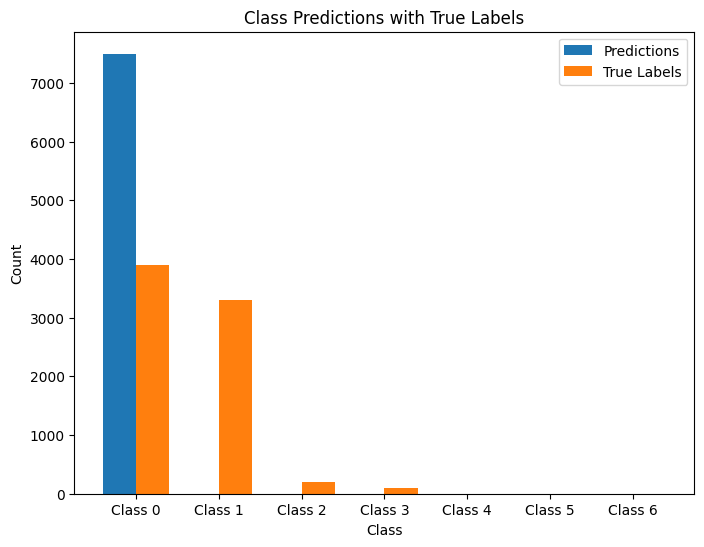

In [85]:
# Lists to store predictions and true labels
all_predictions = []
all_true_labels = []

# Number of classes
num_classes = 7

# Training loop
num_epochs = 100  
for epoch in range(num_epochs):
    total_loss = 0.0
    total_samples = 0

    for inputs, targets in train_dataloader:
        classification_optimizer.zero_grad()
        outputs = classification_model(inputs)
        loss = classification_criterion(outputs, targets)
        loss.backward()
        classification_optimizer.step()

        total_loss += loss.item() * len(inputs)
        total_samples += len(inputs)

    # Calculate accuracy and collect predictions and true labels at the end of each epoch
    total_correct = 0
    total_test_samples = 0
    with torch.no_grad():  # Ensure no gradient computation during evaluation
        for test_inputs, test_targets in test_dataloader:
            test_outputs = classification_model(test_inputs)
            _, predicted = torch.max(test_outputs, 1)  # Get the class with the highest probability
            total_correct += (predicted == test_targets).sum().item()
            total_test_samples += len(test_inputs)

            # Collect predictions and true labels
            all_predictions.extend(predicted.tolist())
            all_true_labels.extend(test_targets.tolist())

    accuracy = total_correct / total_test_samples
    avg_loss = total_loss / total_samples
    
    # Print the training loss and accuracy at the end of each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Avg. Training Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Plot a bar chart for class predictions with true labels
class_counts = [all_predictions.count(i) for i in range(num_classes)]
class_labels = [f'Class {i}' for i in range(num_classes)]
true_labels = [f'True Label {i}' for i in range(num_classes)]

x = np.arange(num_classes) 

plt.figure(figsize=(8, 6))
plt.bar(x - 0.2, class_counts, width=0.4, label='Predictions')
plt.bar(x + 0.2, [all_true_labels.count(i) for i in range(num_classes)], width=0.4, label='True Labels')
plt.xticks(x, class_labels)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Predictions with True Labels')
plt.legend()
plt.show()


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


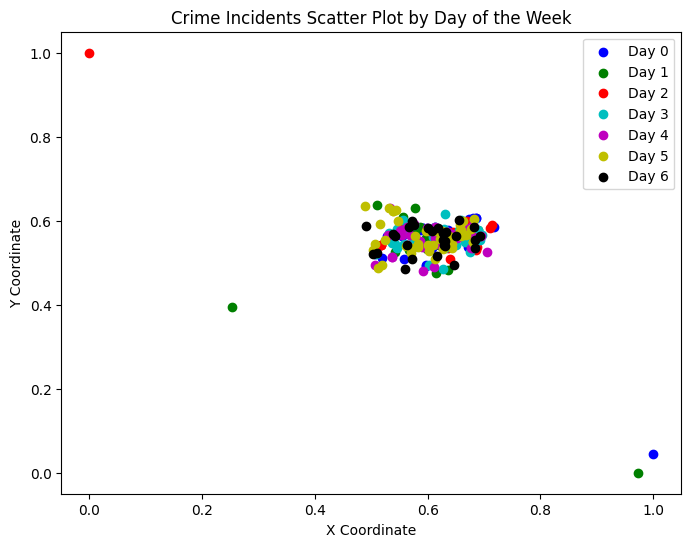

In [87]:
#Different colors for days of the week
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Create a scatter plot
plt.figure(figsize=(8, 6))
for day, color in enumerate(colors):
    day_data = df[df['DayOfWeek'] == day]
    plt.scatter(day_data['X'], day_data['Y'], c=color, label=f'Day {day}')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Crime Incidents Scatter Plot by Day of the Week')
plt.legend()
plt.show()

### The crime rate seems to be concentrated in a particular area as visible in the scatter plot with the X and Y coordinates.

C:\Users\bapat\AppData\Local\Temp\ipykernel_17360\2555426183.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('viridis', max(df['VictimCount']) + 1)


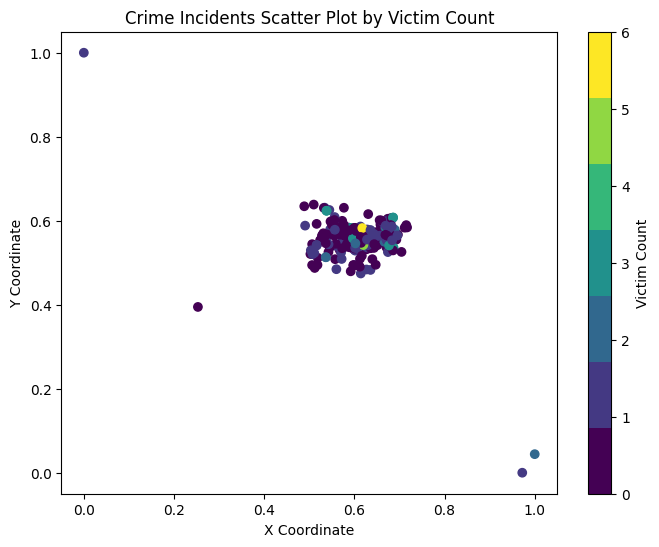

In [88]:
# Define a colormap to map the number of persons to colors
colormap = plt.cm.get_cmap('viridis', max(df['VictimCount']) + 1)

# Create a scatter plot with colors based on the number of persons involved
plt.figure(figsize=(8, 6))
sc = plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap=colormap)
plt.colorbar(sc, label='Victim Count')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Crime Incidents Scatter Plot by Victim Count')
plt.show()

### The scatter plot shows that the crimes are concentrated in an area, also the victim count is mostly 3 or 4.

In [11]:
day_crime_counts = df['DayOfWeek'].value_counts().reset_index()
day_crime_counts.columns = ['DayOfWeek', 'CrimeCount']

# Sort the counts by 'CrimeCount' in descending order
sorted_day_crime_counts = day_crime_counts.sort_values(by='CrimeCount', ascending=False)

In [12]:
sorted_day_crime_counts

,DayOfWeek,CrimeCount
0,4,51
1,3,44
2,5,43
3,0,40
4,1,37
5,2,32
6,6,28


### In pandas day_name() function, 0-6 represents Monday to Sunday, and from the above analysis we can see that most crimes are happening on Fridays.